In [1]:
# !pip install gymnasium

Some imports just to render the results in colab

In [2]:
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

# Introduction to OpenGym using the CartPole problem

OpenGym is an standard testbed for RL algorithms.

https://www.gymlibrary.dev/environments/classic_control/

In this notebook we test our own implementation of Q-learning (see slides of Lecture 2) with OpenGym in the CartPole environment (see slides of Lecture 1).

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import pandas as pd

import gymnasium as gym

## This line changes in colab
env = gym.make('CartPole-v1')

env.reset()

(array([ 0.03440822, -0.03736372, -0.00376998,  0.02479145], dtype=float32),
 {})

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Description of the environment

OpenGym has not very good documentation. Usually you have to go to code to understand the details of the environment you want to use.

In the case of the CartPole, go to:

https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Fortunately, there are some functions implemented that show the minimum necessary information to run the RL algorithms.

In [5]:
# Two discrete actions in the environment (push towards each direction)
print(env.action_space)

Discrete(2)


Means 2 discrete possible actions. In this case:

<table>
<thead>
<tr>
<th>Num</th>
<th>Action</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>Push cart to the left</td>
</tr>
<tr>
<td>1</td>
<td>Push cart to the right</td>
    </tr>
</table>
    
Not because I found this information in documentation of the environment but in the code of the environment (https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L13)

In [6]:
# Four dimensional space.
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


That means *4 variables "Continuous with Bounds"* (box).

There also exist **Discrete** observations.

They can be organized as:

- **Dictionary**, fi. Dict({"position": Discrete(5), "velocity": Box(low=np.array([0,0]),high=np.array([1,5]))}),
- **Tuples** , fi. Tuple([Discrete(5), Box(low=np.array([0,0]),high=np.array([1,5]))]),
- **Multidiscrete**, fi. MultiDiscrete([ 2, 2, 100]),

In [7]:
# Show the limits of each variable

print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


<table>
<thead>
<tr>
<th>Num</th>
<th>Observation</th>
<th>Min</th>
<th>Max</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>Cart Position</td>
<td>-4.8</td>
<td>4.8</td>
</tr>
<tr>
<td>1</td>
<td>Cart Velocity</td>
<td>-&infin;</td>
<td>&infin;</td>
</tr>
<tr>
<td>2</td>
<td>Pole Angle rads</td>
<td>-0.42</td>
<td>0.42</td>
</tr>
<tr>
<td>3</td>
<td>Pole Velocity At Tip</td>
<td>-&infin;</td>
<td>&infin;</td>

## Acting in the environment

The *step* method of the environment returns information after execution of an action (passed as parameter) in the *current* state of the environment. In fact, *step* method returns four values:

- **observation** (*object*): an environment-specific object representing your observation of the environment after the action has been executed. Examples of observations are: pixels from a game screen, joint angles and joint velocities of a robot, or the board state in a board game.
    
- **reward** (*float*): immediate reward obtained after action execution. The scale depends on the environment, but the goal is always to increase your total reward.

- **truncated** (*boolean*): Most (but not all) tasks are divided up into well-defined episodes, and *truncated* being True indicates the episode has been ended for exceeding the time limit.

- **terminated** (*boolean*): If trial has ended or note (terminal state). When True, it’s time to reset the environment again.
    
- **info** (*dict*): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this info for learning.


In [8]:
obs1 = env.reset()  # Starting state
action = env.action_space.sample() # take a random action
obs2, reward, terminated, truncated, info = env.step(action)  # take the action and observe results
print('s =',obs1)
print('a =',action)
print('r =',reward)
print("s'=",obs2)
print(truncated or terminated)

s = (array([-0.04221148,  0.00274743, -0.04219689, -0.02582984], dtype=float32), {})
a = 0
r = 1.0
s'= [-0.04215652 -0.19174477 -0.04271349  0.25324658]
False


That's all the information we need in model-free RL algorithms!

Let's execute now a sequence of random actions. Method *env.render* will show us a visualization of the environment.

In [9]:
# Generate one random trial
env.close()
env = RecordVideo(gym.make('CartPole-v1',render_mode='rgb_array'),video_folder='video')
obs1 = env.reset()
done= False
while not done:
    # env.render()
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample()) # take a random action
    done = truncated or terminated
env.close()
show_video()

/home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/.venv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4


In [10]:
# Let's compute the average return for 10 random trials and the number of timesteps
t=0
tsteps=0
treward=0
for nexps in range(3):   # Let's do 3 trials
    done= False
    env = RecordVideo(gym.make('CartPole-v1',render_mode='rgb_array'),video_folder='video')
    env.reset()
    while not done:
        # env.render()
        observation, reward, terminated, truncated, info = env.step(env.action_space.sample()) # take a random action
        done = truncated or terminated
        treward = treward + reward
        tsteps = tsteps + 1
    env.close()
    show_video()
print('Average reward',treward/10)
print('Average time steps before ending episode',tsteps/10)


/home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/.venv/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4


Moviepy - Building video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4


Moviepy - Building video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4


Average reward 6.5
Average time steps before ending episode 6.5


Trying to apply Q-learning, we have to define the table that will store the Q-value function. But we have a problem here, because our **states are defined by continuous variables**.

One solution could be to discretize values by bining them.

## Discretization of the state

First we have to declare how many "discrete" states I will allow per variable, and later define the discretization procedure

In [11]:
env = gym.make('CartPole-v1')

In [12]:
discr_vector = (1,3,10,20,)   # Resolution degrees: How many discrete states per variable. Play with this parameter!

class Discretizer ():
    """ mins: vector with minimim values allowed for each variable
        maxs: vector with maximum values allowed for each variable
    """
    def __init__(self, vector_discr, mins, maxs):
        self.mins=mins
        self.maxs=maxs

    def Discretize(self, obs):
        ratios = [(obs[i] + abs(self.mins[i])) / (self.maxs[i] - self.mins[i]) for i in range(len(obs))]
        new_obs = [int(round((discr_vector[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(discr_vector[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

# Create the discretizer with maxs and mins from the enviroment
d = Discretizer(discr_vector, env.observation_space.low, env.observation_space.high)

# It will not work because limits for two varaibles are almost infinite (in other case could work)

In [13]:
obs1,_ = env.reset()
print(obs1)
d.Discretize(obs1)

[-0.04238601  0.04464095  0.03269384 -0.02698056]


/tmp/ipykernel_13375/1128260449.py:12: RuntimeWarning: overflow encountered in scalar subtract
  ratios = [(obs[i] + abs(self.mins[i])) / (self.maxs[i] - self.mins[i]) for i in range(len(obs))]


(0, 0, 5, 0)

In [14]:
# Another approach. Try a lot of random actions and find maximum and minimum for each variable empirically
# This approach also has some problems, because some states are found with very low probability.
t=0
tsteps=0
treward=0
lO=np.zeros((100000,4))
for nexp in range(10000):   # Let's do 10 trials
    done= False
    env.reset()
    while not done:
        observation, reward, terminated, truncated, info = env.step(env.action_space.sample()) # take a random action
        done = truncated or terminated
        treward = treward + reward
        tsteps = tsteps + 1
        lO[nexp]=np.array(observation)

maxv=[np.max(lO[:,i]) for i in range(lO.shape[1])]
minv=[np.min(lO[:,i]) for i in range(lO.shape[1])]

# Now we have a better discretization based on common values
d = Discretizer(discr_vector, minv, maxv)

# or even better
minv = [env.observation_space.low[0], minv[1], env.observation_space.low[2], minv[3]]
maxv = [env.observation_space.high[0], maxv[1], env.observation_space.high[2], maxv[3]]
d = Discretizer(discr_vector, minv, maxv)

## Q-learning implementation

#### Define epsilon-greedy procedure

In [15]:
def choose_action(state, epsilon):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(Q[state])


#### Implementation of Q-learning

In [16]:
# Set parameters for learning
alpha = 0.2
epsilon = 0.1
gamma = 1

# Create and initialize Q-value table to 0
Q = np.zeros(discr_vector + (env.action_space.n,))

# Just to store the long-term-reward of the last 100 experiments
scores = deque(maxlen=100)
lrews = []
lr = []

for episode in range(1,10001):
    done = False
    R, reward = 0,0
    state = d.Discretize(env.reset()[0])
    while done != True:
            action = choose_action(state, epsilon)
            obs, reward, terminated, truncated, info = env.step(action)
            done = truncated or terminated
            new_state = d.Discretize(obs)
            Q[state][action] += alpha * (reward +  gamma * np.max(Q[new_state]) - Q[state][action]) #3 (1-terminated) *
            R = gamma * R + reward
            state = new_state
    lr.append(R)
    scores.append(R)
    mean_score = np.mean(scores)
    lrews.append(np.mean(scores))
    if mean_score >= 250 and episode >= 100:
        print('Ran {} episodes. Solved after {} trials ✔'.format(episode, episode - 100))
        break
    if episode % 100 == 0:
        print('Episode {} Total Reward: {} Average Reward: {}'.format(episode,R,np.mean(scores)))


Episode 100 Total Reward: 12.0 Average Reward: 10.11
Episode 200 Total Reward: 10.0 Average Reward: 10.55
Episode 300 Total Reward: 10.0 Average Reward: 12.57
Episode 400 Total Reward: 21.0 Average Reward: 17.88
Episode 500 Total Reward: 196.0 Average Reward: 55.21
Episode 600 Total Reward: 53.0 Average Reward: 104.42
Episode 700 Total Reward: 152.0 Average Reward: 117.44
Episode 800 Total Reward: 155.0 Average Reward: 151.11
Episode 900 Total Reward: 124.0 Average Reward: 157.08
Episode 1000 Total Reward: 165.0 Average Reward: 157.9
Episode 1100 Total Reward: 140.0 Average Reward: 152.16
Episode 1200 Total Reward: 150.0 Average Reward: 159.24
Episode 1300 Total Reward: 127.0 Average Reward: 149.59
Episode 1400 Total Reward: 186.0 Average Reward: 159.49
Episode 1500 Total Reward: 207.0 Average Reward: 195.94
Episode 1600 Total Reward: 140.0 Average Reward: 181.84
Episode 1700 Total Reward: 168.0 Average Reward: 191.34
Episode 1800 Total Reward: 162.0 Average Reward: 187.08
Episode 1900

This is how long term reward increses with episodes. Remember that long-term-reward represents the number of time steps before failure. We decided the task was learnt when the average long-term-reward of the last 100 experiences is higher than 200.

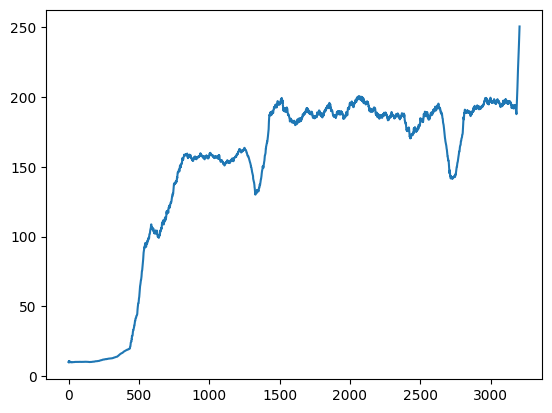

In [18]:
plt.plot(lrews)
plt.show()


Notice that, being results shown are average of last 100 experiments, there is a "delay" of 100 episodes in detecting that desired behavior has been learnt. We could plot the actual reward for each episode, but is too varaible to see anything. It is better to average returns.

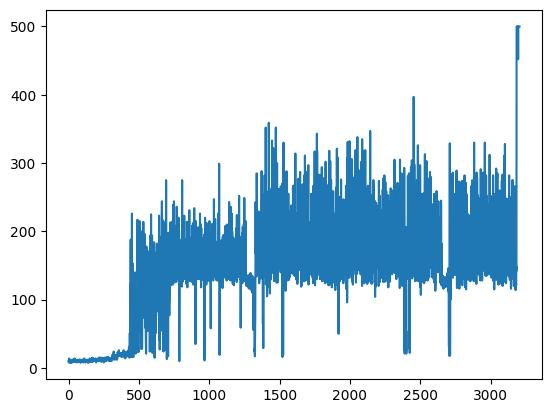

In [19]:
plt.plot(lr)
plt.show()

Why so many peaks? Remember! We take random actions with probability $\epsilon$. Notice difference in performance when we set epsilon to zero. That's because we use an off-policy method.

In [22]:
def rollout(epsilon, render=True, envname='CartPole-v1'):
    if render:
      env = RecordVideo(gym.make('CartPole-v1',render_mode='rgb_array'),video_folder='video')
    else:
      env = gym.make(envname)
    done = False
    R, reward = 0,0
    state = d.Discretize(env.reset()[0])
    while done != True:
            # if render:
                # env.render()
            action = choose_action(state, epsilon)
            obs, reward, terminated, truncated, info = env.step(action)
            done = truncated or terminated
            R = gamma * R + reward
            state = d.Discretize(obs)
    env.close()
    if render:
      show_video()
    return R


rollout(epsilon)
rollout(0)

print('Average reward for epsilon',epsilon,':', np.mean([rollout(epsilon, render=False) for _ in range(20)]))
print('Average reward for epsilon 0:', np.mean([rollout(0,render=False) for _ in range(20)]))

Moviepy - Building video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4


Moviepy - Building video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4


Average reward for epsilon 0.1 : 161.25
Average reward for epsilon 0: 161.7


In [23]:

env = gym.make('CartPole-v1')

But instead of stopping after return in last 100 experiments is higher than 200, let's iterate a fixed number of experiences

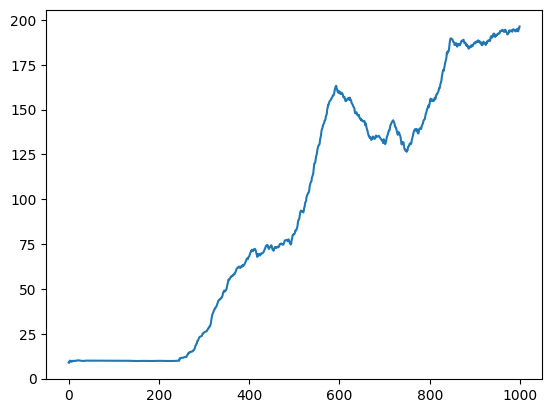

In [24]:
# Set parameters for learning
alpha = 0.2
epsilon = 0.1
gamma = 1

# Create and initialize Q-value table to 0
Q = np.zeros(discr_vector + (env.action_space.n,))

# Just to store the long-term-reward of the last 100 experiments
scores = deque(maxlen=100)
lrews = []

for episode in range(1,1001):
    done = False
    R, reward = 0,0
    state = d.Discretize(env.reset()[0])
    while done != True:
            action = choose_action(state, epsilon)
            obs, reward, terminated, truncated, info = env.step(action)
            done = truncated or terminated
            new_state = d.Discretize(obs)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[state][action]) #3
            R = gamma * R + reward
            state = new_state
    scores.append(R)
    mean_score = np.mean(scores)
    lrews.append(np.mean(scores))

plt.plot(lrews)
plt.show()

Inestability can be produced because we had not good enough discretization and/or large alpha values and/or large epsilon values.


Not bad. However, in RL results depend a lot on randomization, so it's a good thing repeat several times the same procedure

In [28]:
l100rew=[]
for _ in range(50):
    print('*** New experiment!')
    # Create and initialize Q-value table to 0
    Q = np.zeros(discr_vector + (env.action_space.n,))

    # Just to store the long-term-reward of the last 100 experiments
    scores = deque(maxlen=100)
    lrews = []

    for episode in range(1,1001):
        done = False
        R, reward = 0,0
        state = d.Discretize(env.reset()[0])
        while done != True:
                action = choose_action(state, epsilon)
                obs, reward, terminated, truncated, info = env.step(action)
                done = truncated or terminated
                new_state = d.Discretize(obs)
                Q[state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[state][action]) #3

                R = gamma * R + reward
                state = new_state
        scores.append(R)
        mean_score = np.mean(scores)
        lrews.append(np.mean(scores))
        #if mean_score >= 195 and episode >= 100:
        #    print('Ran {} episodes. Solved after {} trials ✔'.format(episode, episode - 100))
        #    break
        #if episode % 100 == 0:
        #    print('Episode {} Total Reward: {} Average Reward: {}'.format(episode,G,np.mean(scores)))
    l100rew.append(lrews)



*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!


In [29]:
def tsplot(data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    plt.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    plt.plot(x,est,**kw)
    plt.margins(x=0)

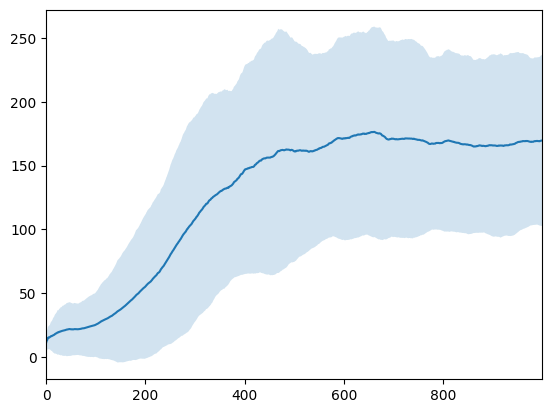

In [31]:
tsplot(data=np.array(l100rew)) #, err_style="unit_traces")
plt.show()

Not very smooth and somewhat slow in learning. We could do better setting a variable alpha and epsilon (why?)

$$ \epsilon = \max \left( \epsilon_{min}, 1- \log \frac{t+1}{tau} \right) $$
$$ \alpha = \max \left( \alpha_{min}, 1- \log \frac{t+1}{tau} \right) $$

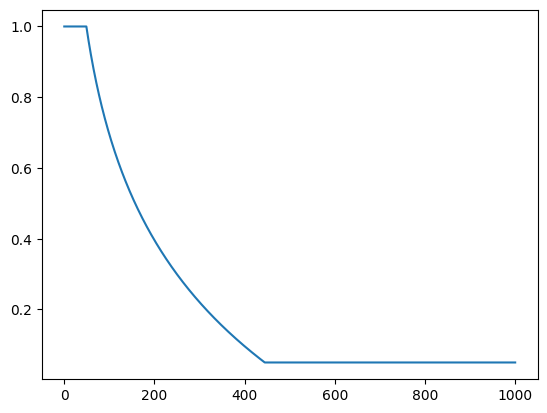

In [32]:
min_alpha=0.05
min_epsilon = 0.01
tau = 50

def set_epsilon(t, tau):
    return max(min_epsilon, min(1, 1.0 - math.log10((t + 1) / tau)))

def set_alpha(t, tau):
    return max(min_alpha, min(1.0, 1.0 - math.log10((t + 1) / tau)))

plt.plot([set_alpha(i, tau) for i in range(1001)])
plt.show()

*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!
*** New experiment!


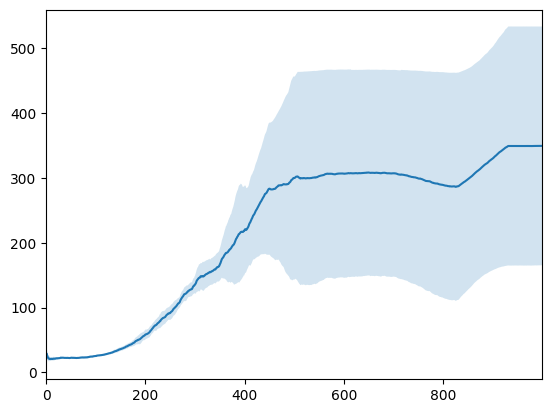

In [35]:
l100rew=[]
for _ in range(5):
    print('*** New experiment!')
    # Create and initialize Q-value table to 0
    Q = np.zeros(discr_vector + (env.action_space.n,))

    # Just to store the long-term-reward of the last 100 experiments
    scores = deque(maxlen=100)
    lrews = []

    for episode in range(1,1001):
        done = False
        e = set_epsilon(episode, tau)
        a = set_alpha(episode, tau)
        R, reward = 0,0
        state = d.Discretize(env.reset()[0])
        while done != True:
                action = choose_action(state, e)
                obs, reward, terminated, truncated, info = env.step(action)
                done = truncated or terminated
                new_state = d.Discretize(obs)
                Q[state][action] += alpha * (reward +  gamma * np.max(Q[new_state]) - Q[state][action]) #3

                R = gamma * R + reward
                state = new_state
        scores.append(R)
        mean_score = np.mean(scores)
        lrews.append(np.mean(scores))
    l100rew.append(lrews)

tsplot(data=np.array(l100rew)) #, err_style="unit_traces")
plt.show()

In [36]:
print('Average reward for epsilon 0:', np.mean([rollout(0,render=False) for _ in range(100)]))
rollout(0)

Average reward for epsilon 0: 500.0
Moviepy - Building video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4.
Moviepy - Writing video /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/video/rl-video-episode-0.mp4


500.0

## Exercises

1. Play with parameters for discretization and see how they affect performance and convergence
2. Try other methods to decrese $\alpha$ and $\epsilon$
3. Try Boltzman exploration instead of $\epsilon$ greedy
4. Obtain Q-values for starting state. Is that strange? Can you explain/solve the problem using gamma different to 1? Try with gamma 0.99 for example.
5. **Implement Monte-Carlo for this problem and compare performance and variance with Q-learning**
6. **Implement n-steps Q-learning for this problem and compare performance with Q-learning**
7. **Implement Sarsa on this problem**
8. **Adapt everything has been done here to another Gym problem, f.i. Acrobot-v1 or MountainCar-v0**

In [ ]:
env.close()